In [1]:
import pertpy as pt
import scanpy as sc
from scvi import REGISTRY_KEYS

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWar

In [2]:
import random
import numpy as np
import torch
import os
import sklearn

def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
adata = sc.read_h5ad('../data/PBMC_yale.h5ad')
adata = adata[adata.obs['perturbation'].isin(['No stimulation','IFNb']),:].copy()

In [4]:
pt.tl.Scgen.setup_anndata(adata, batch_key='perturbation', labels_key='cell_type0528')

In [5]:
scgen_model = pt.tl.Scgen(adata)

In [6]:
scgen_model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator="cpu",
)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 737.358. Signaling Trainer to stop.


In [7]:
scgen_model.save("./scgen/model_perturbation_prediction.pt", overwrite=True)

In [8]:
latent_X = scgen_model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

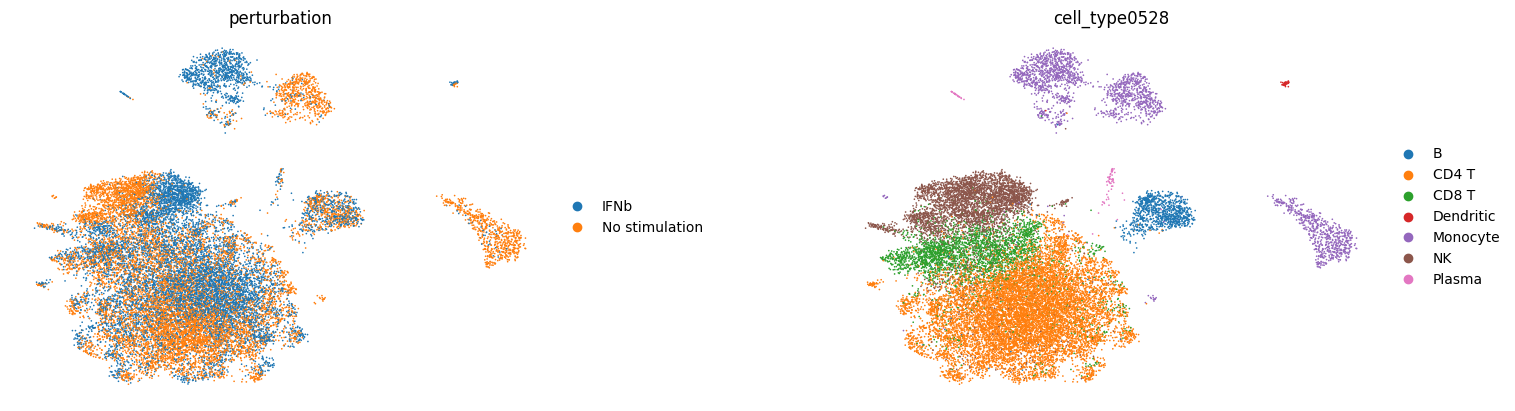

In [9]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(
    latent_adata,
    color=['perturbation', 'cell_type0528'],
    wspace=0.4,
    frameon=False
)

In [10]:
import rpy2.robjects as robjects

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()


import anndata2ri
anndata2ri.activate()
# Add your library path
library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
# Update R's library paths
robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
# Verify the updated library paths
print(robjects.r('.libPaths()'))

anndata2ri.activate()
%load_ext rpy2.ipython

latent_adata.obsm["latent"]=latent_X

from metrics import calculate_metrics

try:
    calculate_metrics(latent_adata, batch_key='perturbation', celltype_key='cell_type0528', all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + "PBMC_yale" + ".csv")
except:
    calculate_metrics(latent_adata, batch_key='perturbation', celltype_key='cell_type0528', all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + "PBMC_yale" + ".csv")

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---


cLISI, bLISI, LISI_F1 0.9626202452720904 0.4280172628284003 0.5925600023364106


ASW---


asw_label 0.533076573163271


asw_batch 0.9160810357318364


kBET---


0 labels consist of a single batch or is too small. Skip.


kbet_score 0.4590544615019715
graph_conn 0.9979491100451953


NMI, ARI ---
NMI 0.6107328065145372
ARI 0.6083373873600125
positive and true positive rate---


        ASW_label       ARI       NMI  1-cLISI     bLISI  ASW_batch  \
latent   0.533077  0.608337  0.610733  0.96262  0.428017   0.916081   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.459054            0.997949        0.0  0.916374   

        true pos rate  F1 LISI  
latent       0.243816  0.59256  


In [11]:
def run_scgen(adata, condition_key, cell_type_key,exp_label, ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata=adata.copy()
    
    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]].copy()
    
    pt.tl.Scgen.setup_anndata(adata, batch_key=condition_key, labels_key=cell_type_key)
    scgen_model = pt.tl.Scgen(adata)

    scgen_model.train(
        max_epochs=100,
        batch_size=32,
        early_stopping=True,
        early_stopping_patience=25,
        #accelerator="cpu",
    )

    scgen_model.save("./scgen/"+dataset_name+".pt", overwrite=True)

    latent_X = scgen_model.get_latent_representation()
    latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
    latent_adata.obsm["latent"]=latent_X

    sc.pp.neighbors(latent_adata)
    sc.tl.umap(latent_adata)
    sc.pl.umap(
        latent_adata,
        color=[condition_key, cell_type_key],
        wspace=0.4,
        frameon=False
    )
    latent_adata.write("./scgen/" + dataset_name + ".h5ad")

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    try:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + dataset_name + ".csv")
    except:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + dataset_name + ".csv")

# PBMC (yale)

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1023.089. Signaling Trainer to stop.


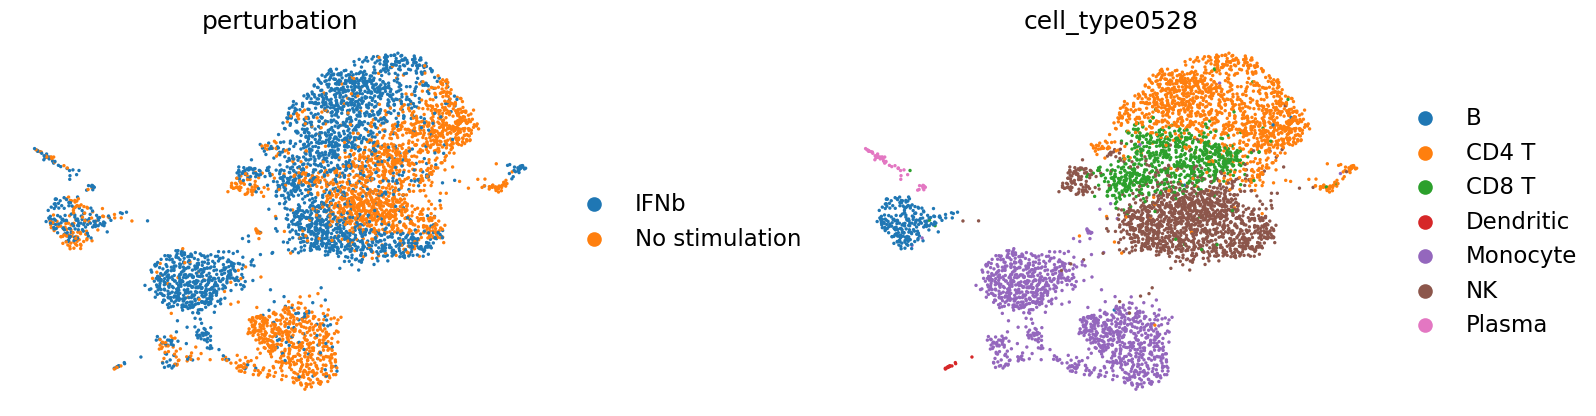

LISI---


cLISI, bLISI, LISI_F1 0.9462196491038722 0.37068349521908667 0.5326861102683847


ASW---
asw_label 0.5268478468060493


asw_batch 0.9097499153884812
kBET---


0 labels consist of a single batch or is too small. Skip.


kbet_score 0.4858618074640022
graph_conn 0.9977513654027126


NMI, ARI ---
NMI 0.6877634173030268
ARI 0.6159676959631499
positive and true positive rate---


        ASW_label       ARI       NMI  1-cLISI     bLISI  ASW_batch  \
latent   0.526848  0.615968  0.687763  0.94622  0.370683    0.90975   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.485862            0.997751        0.0  0.913865   

        true pos rate   F1 LISI  
latent       0.213248  0.532686  


In [12]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
run_scgen(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

# PBMC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583

https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 126.854. Signaling Trainer to stop.


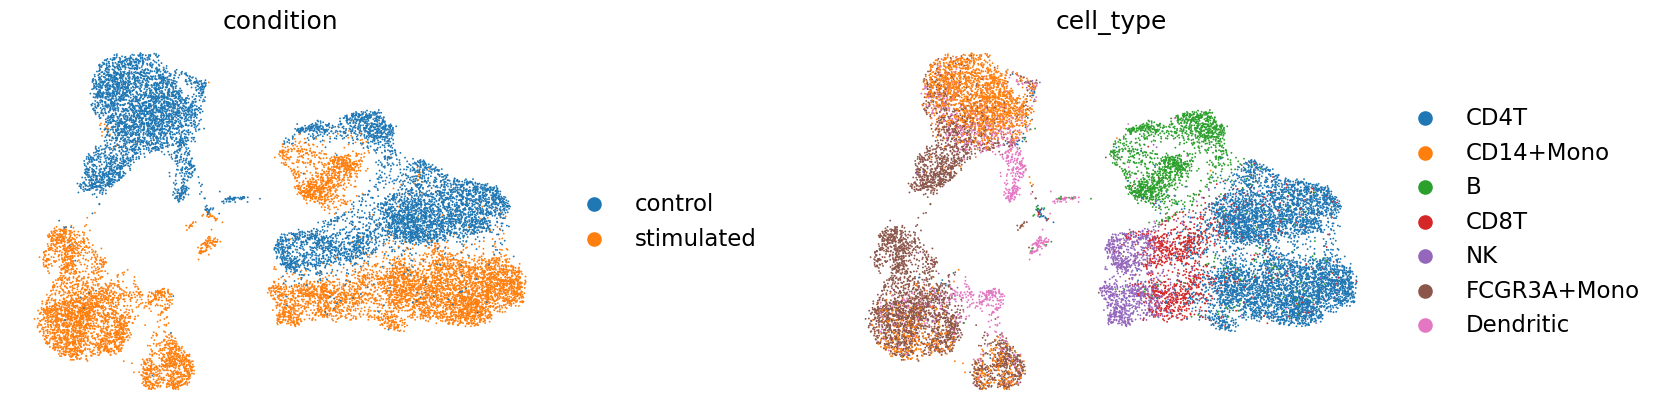

LISI---


cLISI, bLISI, LISI_F1 0.9413092386527133 0.05446735664034194 0.10297616202850647


ASW---


asw_label 0.5413122214376926


asw_batch 0.7586164586046744


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


kbet_score 0.017197460258943198
graph_conn 0.9705319605370758


NMI, ARI ---
NMI 0.6000586041338172
ARI 0.4758275650863633
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.541312  0.475828  0.600059  0.941309  0.054467   0.758616   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.017197            0.970532        0.0  0.836204   

        true pos rate   F1 LISI  
latent       0.021074  0.102976  


In [13]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC.h5ad')
run_scgen(adata=adata, condition_key='condition', cell_type_key='cell_type', exp_label='stimulated', ref_label='control', dataset_name="PBMC")

# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 12255 × 3608
    obs: 'batch', 'leiden', 'cell_type1021', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 2104.358. Signaling Trainer to stop.


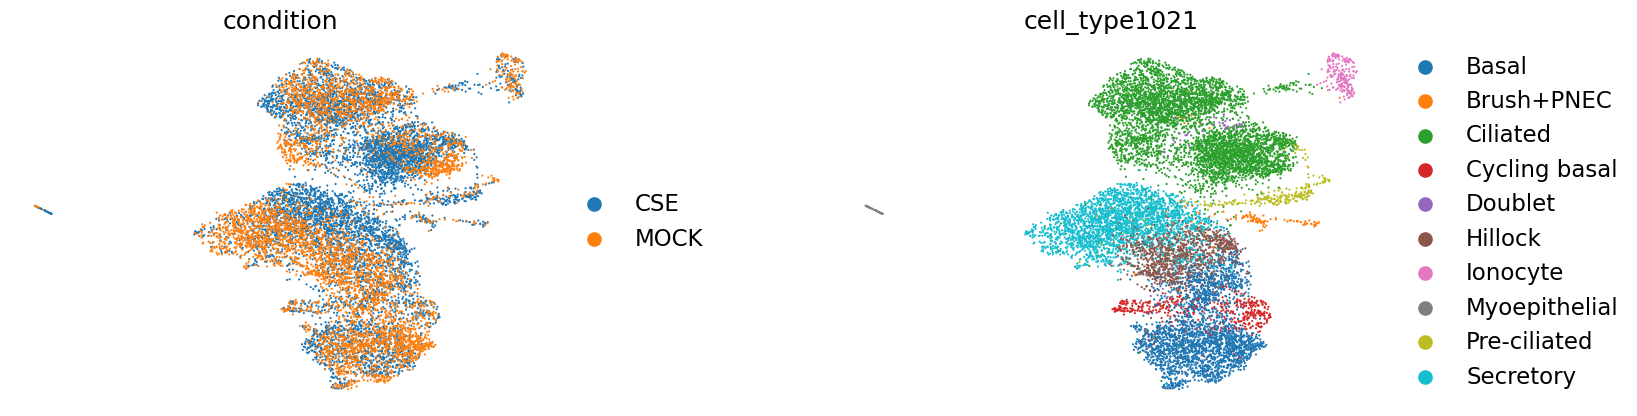

LISI---


cLISI, bLISI, LISI_F1 0.9775951533466863 0.5118427210385306 0.6718977299668618


ASW---


asw_label 0.4991321434499696


asw_batch 0.914148787013


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


kbet_score 0.5437648289192362
graph_conn 0.9937474776720399


NMI, ARI ---
NMI 0.7139525269527801
ARI 0.7099950883463028
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.499132  0.709995  0.713953  0.977595  0.511843   0.914149   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.543765            0.993747        0.0   0.93366   

        true pos rate   F1 LISI  
latent       0.369645  0.671898  


In [14]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["condition"]=adata.obs["batch"].copy()
run_scgen(adata=adata, condition_key='condition', cell_type_key="cell_type1021", exp_label='CSE', ref_label='MOCK', dataset_name="virus")

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HTO_classification_colors', 'MULTI_ID_colors', 'Phase_colors', 'gene_target_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 385.412. Signaling Trainer to stop.


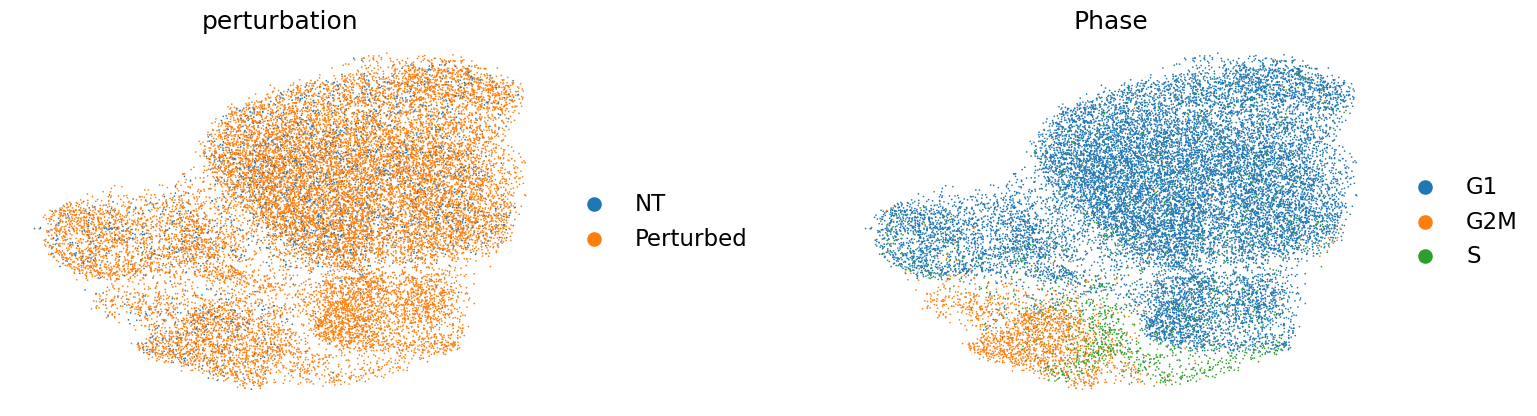

LISI---


cLISI, bLISI, LISI_F1 0.9154782655675464 0.26103751702508343 0.40624048885696484


ASW---


asw_label 0.5060699437744915


asw_batch 0.976763968509811


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


kbet_score 0.8837283992949339
graph_conn 0.9386529420630577


NMI, ARI ---
NMI 0.3037855003992622
ARI 0.3258301475767778
positive and true positive rate---


        ASW_label      ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent    0.50607  0.32583  0.303786  0.915478  0.261038   0.976764   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.883728            0.938653        0.0  0.934681   

        true pos rate  F1 LISI  
latent       0.847942  0.40624  


In [15]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_scgen(adata=adata, condition_key='perturbation', cell_type_key="Phase", exp_label='NT', ref_label='Perturbed', dataset_name="ECCITE")

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

AnnData object with n_obs × n_vars = 49067 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


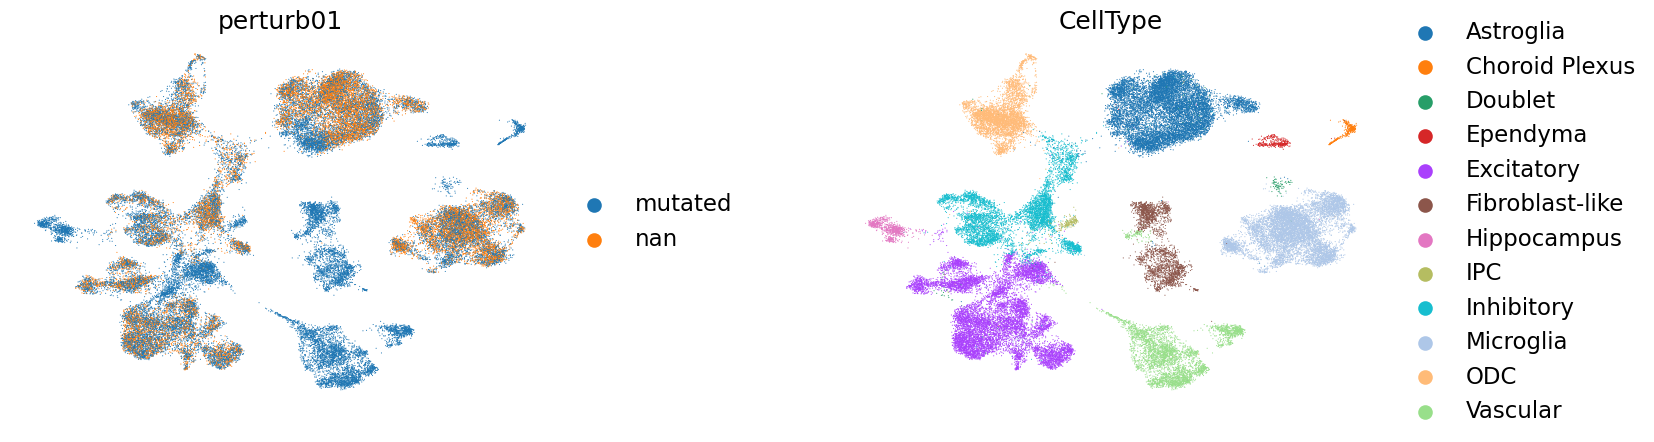

Cell cluster Vascular contains only one batch or has less than 10 cells. Skip.
Cell cluster Fibroblast-like contains only one batch or has less than 10 cells. Skip.
Cell cluster IPC contains only one batch or has less than 10 cells. Skip.
Cell cluster Doublet contains only one batch or has less than 10 cells. Skip.
Cell cluster Ependyma contains only one batch or has less than 10 cells. Skip.
Cell cluster Hippocampus contains only one batch or has less than 10 cells. Skip.
Cell cluster Choroid Plexus contains only one batch or has less than 10 cells. Skip.
LISI---


cLISI, bLISI, LISI_F1 0.9959005373969251 0.7440031377117245 0.8517174085810647


ASW---


asw_label 0.5324015505611897


asw_batch 0.9838421800520489


kBET---


7 labels consist of a single batch or is too small. Skip.


kbet_score 0.7078323669290303
graph_conn 0.9913409136260674


NMI, ARI ---
NMI 0.9465685765992654
ARI 0.9593014329988466
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.532402  0.959301  0.946569  0.995901  0.744003   0.983842   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.707832            0.991341        0.0   0.98769   

        true pos rate   F1 LISI  
latent       0.841767  0.851717  


In [16]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_scgen(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD")